# Model Evaluation & Performance Analysis

## Цель
Комплексная оценка производительности моделей предсказания покупок.

## Содержание
1. **Performance Metrics** - AUC, Precision, Recall, F1, Log Loss
2. **Model Comparison** - Baseline vs Final models
3. **Visualizations** - ROC, PR curves, confusion matrix, calibration
4. **Error Analysis** - False positives/negatives, worst predictions
5. **Feature Importance** - Top features, SHAP analysis
6. **Cross-Validation** - Stability analysis

## Expected Results
- **Target AUC:** 0.77+
- **F1-Score:** 0.45+
- 10-12 publication-ready visualizations

## 1. Imports and Configuration

In [2]:
import pandas as pd
import numpy as np
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    precision_score, recall_score, f1_score,
    accuracy_score, log_loss,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP available")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not available. Install with: pip install shap")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

✅ SHAP available
Libraries loaded successfully!


In [3]:
# Configuration
DATA_DIR = '../results'
MODELS_DIR = '../models'
FIGURES_DIR = '../results/figures'

# Create directories
os.makedirs(FIGURES_DIR, exist_ok=True)

# Random seed
RANDOM_STATE = 42

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Random state: {RANDOM_STATE}")

Data directory: ../results
Models directory: ../models
Figures directory: ../results/figures
Random state: 42


## 2. Load Data and Models

In [4]:
# Load training data with features
print("Loading features...")
df_train = pd.read_parquet(os.path.join(DATA_DIR, 'features_train_v2.parquet'))

print(f"\nData shape: {df_train.shape}")
print(f"Target distribution:")
print(df_train['target'].value_counts())
print(f"Positive rate: {df_train['target'].mean():.2%}")

df_train.head()

Loading features...

Data shape: (1835147, 337)
Target distribution:
target
0    1200425
1     634722
Name: count, dtype: int64
Positive rate: 34.59%


,user_id,target,num_products_click,num_unique_products_click,sum_discount_price_click,max_discount_price_click,days_since_last_click,days_since_first_click,num_products_favorite,num_unique_products_favorite,...,timestamp_std_search_0_4,timestamp_std_search_1_4,timestamp_std_search_2_4,timestamp_std_search_3_4,timestamp_std_search_4_4,unique_widget_search_0_4,unique_widget_search_1_4,unique_widget_search_2_4,unique_widget_search_3_4,unique_widget_search_4_4
0,16,0,1.0,1.0,335.0,335.0,118.0,118.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,34,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,36,1,9.0,9.0,20407.0,17257.0,49.0,73.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
3,53,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,54,0,1.0,1.0,110.0,110.0,4.0,4.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021505


In [5]:
# Prepare features and target
feature_cols = [col for col in df_train.columns if col not in ['user_id', 'target']]

X = df_train[feature_cols]
y = df_train['target']

print(f"Features shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Target shape: {y.shape}")

Features shape: (1835147, 335)
Number of features: 335
Target shape: (1835147,)


In [6]:
# Load models
print("Loading models...\n")

# CatBoost
catboost_model = CatBoostClassifier()
catboost_model.load_model(os.path.join(MODELS_DIR, 'catboost_model_v2.bin'))
print("✅ CatBoost model loaded")

# LightGBM
lightgbm_model = lgb.Booster(model_file=os.path.join(MODELS_DIR, 'lightgbm_model_v2.txt'))
print("✅ LightGBM model loaded")

# Load ensemble config if exists
ensemble_config_path = os.path.join(MODELS_DIR, 'ensemble_config_v1.json')
if os.path.exists(ensemble_config_path):
    with open(ensemble_config_path, 'r') as f:
        ensemble_config = json.load(f)
    print(f"✅ Ensemble config loaded: {ensemble_config}")
else:
    # Default ensemble weights
    ensemble_config = {
        'catboost_weight': 0.6,
        'lightgbm_weight': 0.4
    }
    print(f"⚠️ Using default ensemble weights: {ensemble_config}")

Loading models...

✅ CatBoost model loaded
✅ LightGBM model loaded
✅ Ensemble config loaded: {'weight_catboost': 0.7, 'weight_lgb': 0.3, 'validation_auc': {'catboost': 0.7618113775207064, 'lightgbm': 0.7618139835994399, 'ensemble': 0.7619285183432558}}


## 3. Generate Predictions

In [8]:
print("Generating predictions...\n")

# CatBoost predictions
y_pred_catboost = catboost_model.predict_proba(X)[:, 1]
print(f"✅ CatBoost predictions: {y_pred_catboost.shape}")
print(f"   Range: [{y_pred_catboost.min():.4f}, {y_pred_catboost.max():.4f}]")

# LightGBM predictions
y_pred_lightgbm = lightgbm_model.predict(X)
print(f"✅ LightGBM predictions: {y_pred_lightgbm.shape}")
print(f"   Range: [{y_pred_lightgbm.min():.4f}, {y_pred_lightgbm.max():.4f}]")

# Ensemble predictions
y_pred_ensemble = (
    ensemble_config['weight_catboost'] * y_pred_catboost +
    ensemble_config['weight_lgb'] * y_pred_lightgbm
)
print(f"\n✅ Ensemble predictions: {y_pred_ensemble.shape}")
print(f"   Range: [{y_pred_ensemble.min():.4f}, {y_pred_ensemble.max():.4f}]")
print(f"   Mean: {y_pred_ensemble.mean():.4f}")
print(f"   Median: {np.median(y_pred_ensemble):.4f}")

Generating predictions...

✅ CatBoost predictions: (1835147,)
   Range: [0.0118, 0.9982]
✅ LightGBM predictions: (1835147,)
   Range: [0.0217, 0.9996]

✅ Ensemble predictions: (1835147,)
   Range: [0.0181, 0.9984]
   Mean: 0.3459
   Median: 0.2176


## 4. Performance Metrics

In [9]:
def calculate_metrics(y_true, y_pred_proba, threshold=0.5, model_name="Model"):
    """
    Calculate comprehensive metrics for binary classification.
    """
    # Binary predictions
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'AUC-ROC': roc_auc_score(y_true, y_pred_proba),
        'Precision': precision_score(y_true, y_pred_binary),
        'Recall': recall_score(y_true, y_pred_binary),
        'F1-Score': f1_score(y_true, y_pred_binary),
        'Accuracy': accuracy_score(y_true, y_pred_binary),
        'Log Loss': log_loss(y_true, y_pred_proba),
        'Brier Score': brier_score_loss(y_true, y_pred_proba),
        'Avg Precision': average_precision_score(y_true, y_pred_proba),
        'Threshold': threshold
    }
    
    return metrics

# Calculate metrics for all models
print("="*70)
print("PERFORMANCE METRICS (threshold=0.5)")
print("="*70)

metrics_catboost = calculate_metrics(y, y_pred_catboost, model_name="CatBoost")
metrics_lightgbm = calculate_metrics(y, y_pred_lightgbm, model_name="LightGBM")
metrics_ensemble = calculate_metrics(y, y_pred_ensemble, model_name="Ensemble")

# Create metrics dataframe
metrics_df = pd.DataFrame([metrics_catboost, metrics_lightgbm, metrics_ensemble])
metrics_df = metrics_df.set_index('Model')

print("\n", metrics_df.round(4))

# Save metrics
metrics_df.to_csv(os.path.join(MODELS_DIR, 'model_metrics_comparison.csv'))
print(f"\n✅ Metrics saved to {MODELS_DIR}/model_metrics_comparison.csv")

PERFORMANCE METRICS (threshold=0.5)

           AUC-ROC  Precision  Recall  F1-Score  Accuracy  Log Loss  \
Model                                                                
CatBoost   0.7627     0.7523  0.4685    0.5774    0.7628    0.5166   
LightGBM   0.7644     0.7547  0.4690    0.5785    0.7636    0.5135   
Ensemble   0.7633     0.7530  0.4688    0.5778    0.7631    0.5154   

          Brier Score  Avg Precision  Threshold  
Model                                            
CatBoost       0.1698         0.6928        0.5  
LightGBM       0.1688         0.6982        0.5  
Ensemble       0.1695         0.6949        0.5  

✅ Metrics saved to ../models/model_metrics_comparison.csv


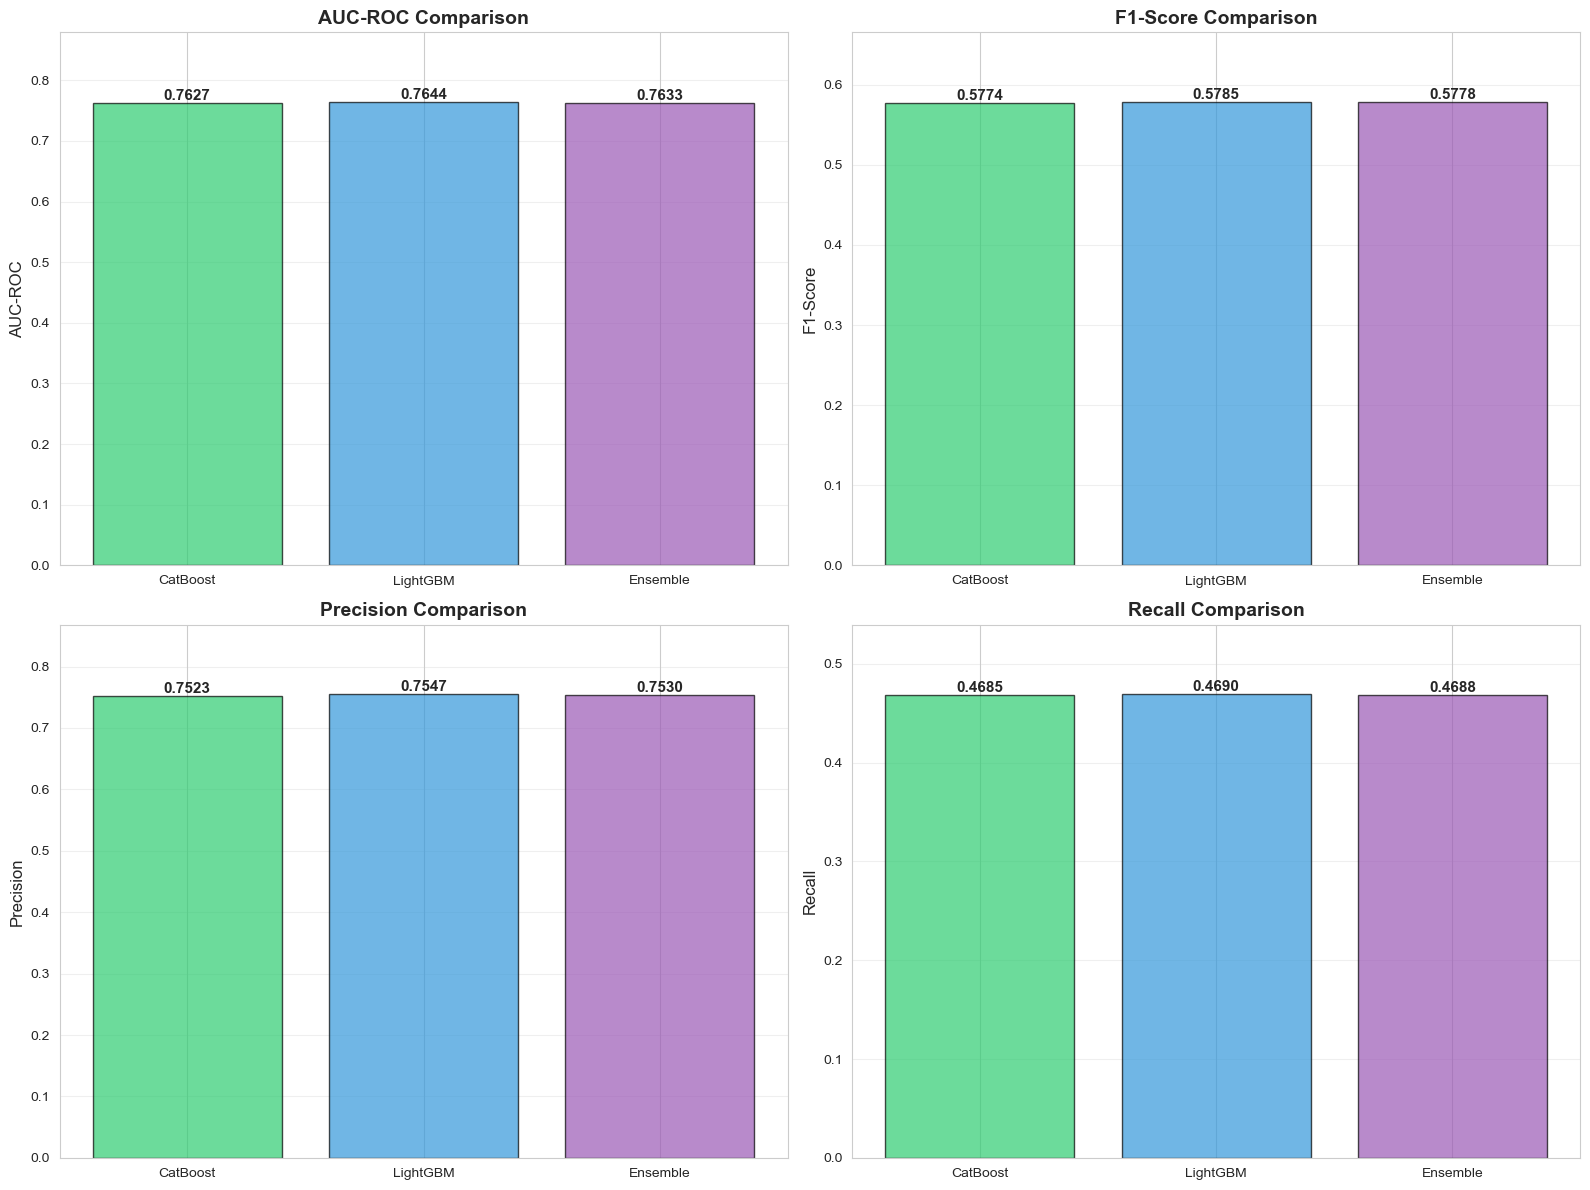

✅ Plot saved to ../results/figures/metrics_comparison.png


In [10]:
# Metrics comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['AUC-ROC', 'F1-Score', 'Precision', 'Recall']
colors = ['#2ecc71', '#3498db', '#9b59b6']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    values = metrics_df[metric].values
    models = metrics_df.index.tolist()
    
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, max(values) * 1.15])

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'metrics_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to {FIGURES_DIR}/metrics_comparison.png")

## 5. ROC Curve Analysis

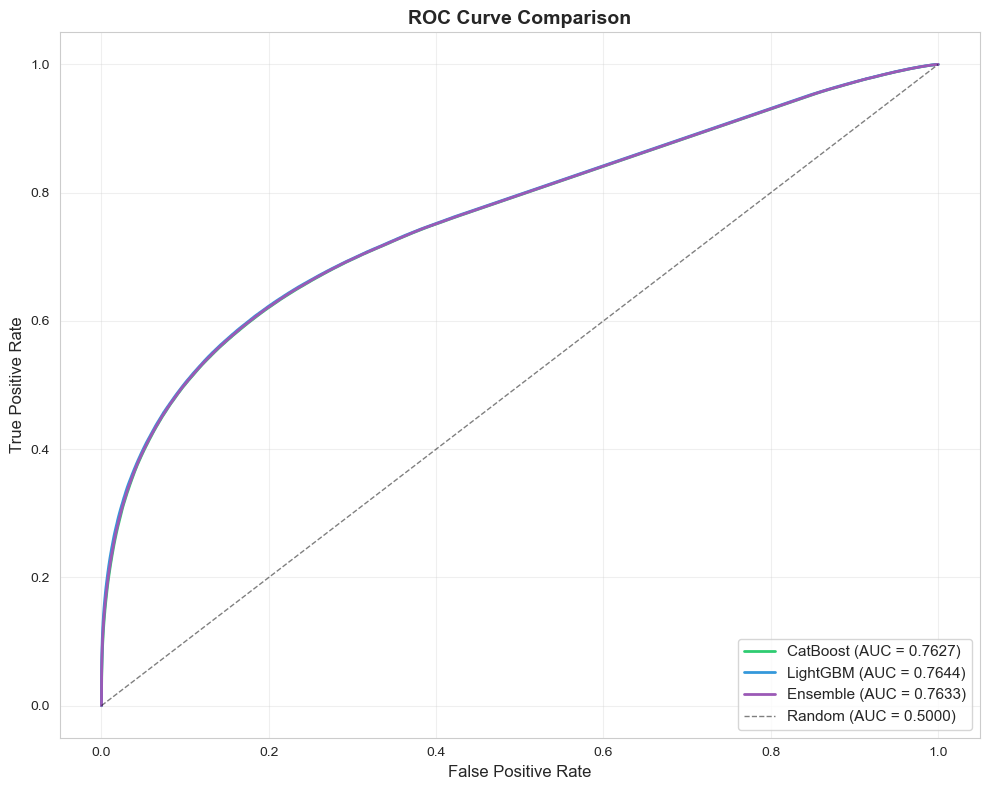

✅ ROC curves saved to ../results/figures/roc_curve_comparison.png


In [11]:
# Calculate ROC curves
fpr_catboost, tpr_catboost, _ = roc_curve(y, y_pred_catboost)
fpr_lightgbm, tpr_lightgbm, _ = roc_curve(y, y_pred_lightgbm)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y, y_pred_ensemble)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_catboost, tpr_catboost, linewidth=2, label=f'CatBoost (AUC = {metrics_catboost["AUC-ROC"]:.4f})', color='#2ecc71')
plt.plot(fpr_lightgbm, tpr_lightgbm, linewidth=2, label=f'LightGBM (AUC = {metrics_lightgbm["AUC-ROC"]:.4f})', color='#3498db')
plt.plot(fpr_ensemble, tpr_ensemble, linewidth=2, label=f'Ensemble (AUC = {metrics_ensemble["AUC-ROC"]:.4f})', color='#9b59b6')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5000)', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ ROC curves saved to {FIGURES_DIR}/roc_curve_comparison.png")

## 6. Precision-Recall Curve

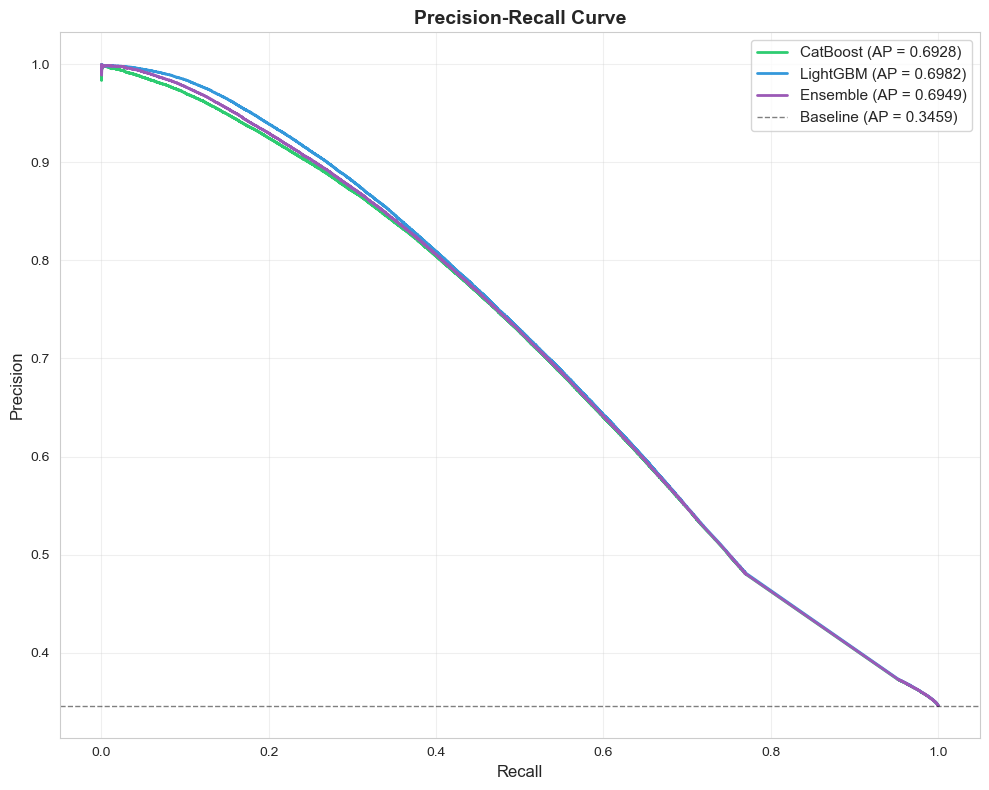

✅ PR curve saved to ../results/figures/precision_recall_curve.png


In [12]:
# Calculate PR curves
precision_catboost, recall_catboost, _ = precision_recall_curve(y, y_pred_catboost)
precision_lightgbm, recall_lightgbm, _ = precision_recall_curve(y, y_pred_lightgbm)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y, y_pred_ensemble)

# Plot PR curves
plt.figure(figsize=(10, 8))

plt.plot(recall_catboost, precision_catboost, linewidth=2, 
         label=f'CatBoost (AP = {metrics_catboost["Avg Precision"]:.4f})', color='#2ecc71')
plt.plot(recall_lightgbm, precision_lightgbm, linewidth=2, 
         label=f'LightGBM (AP = {metrics_lightgbm["Avg Precision"]:.4f})', color='#3498db')
plt.plot(recall_ensemble, precision_ensemble, linewidth=2, 
         label=f'Ensemble (AP = {metrics_ensemble["Avg Precision"]:.4f})', color='#9b59b6')
plt.axhline(y=y.mean(), color='k', linestyle='--', linewidth=1, 
            label=f'Baseline (AP = {y.mean():.4f})', alpha=0.5)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'precision_recall_curve.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ PR curve saved to {FIGURES_DIR}/precision_recall_curve.png")

## 7. Confusion Matrix

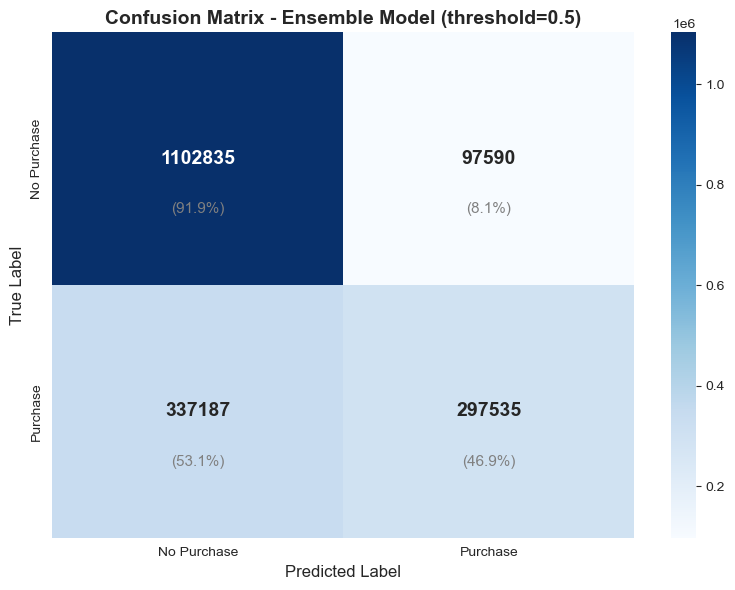


✅ Confusion matrix saved to ../results/figures/confusion_matrix_ensemble.png

Confusion Matrix:
  True Negatives:  1,102,835 (91.9%)
  False Positives: 97,590 (8.1%)
  False Negatives: 337,187 (53.1%)
  True Positives:  297,535 (46.9%)


In [13]:
# Calculate confusion matrices
threshold = 0.5

y_pred_ensemble_binary = (y_pred_ensemble >= threshold).astype(int)
cm = confusion_matrix(y, y_pred_ensemble_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))

# Normalize for percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'],
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})

# Add percentage annotations
for i in range(2):
    for j in range(2):
        plt.text(j + 0.5, i + 0.7, f'({cm_norm[i, j]:.1%})',
                ha='center', va='center', fontsize=11, color='gray')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title(f'Confusion Matrix - Ensemble Model (threshold={threshold})', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_ensemble.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Confusion matrix saved to {FIGURES_DIR}/confusion_matrix_ensemble.png")
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,} ({cm_norm[0,0]:.1%})")
print(f"  False Positives: {cm[0,1]:,} ({cm_norm[0,1]:.1%})")
print(f"  False Negatives: {cm[1,0]:,} ({cm_norm[1,0]:.1%})")
print(f"  True Positives:  {cm[1,1]:,} ({cm_norm[1,1]:.1%})")

## 8. Prediction Distribution

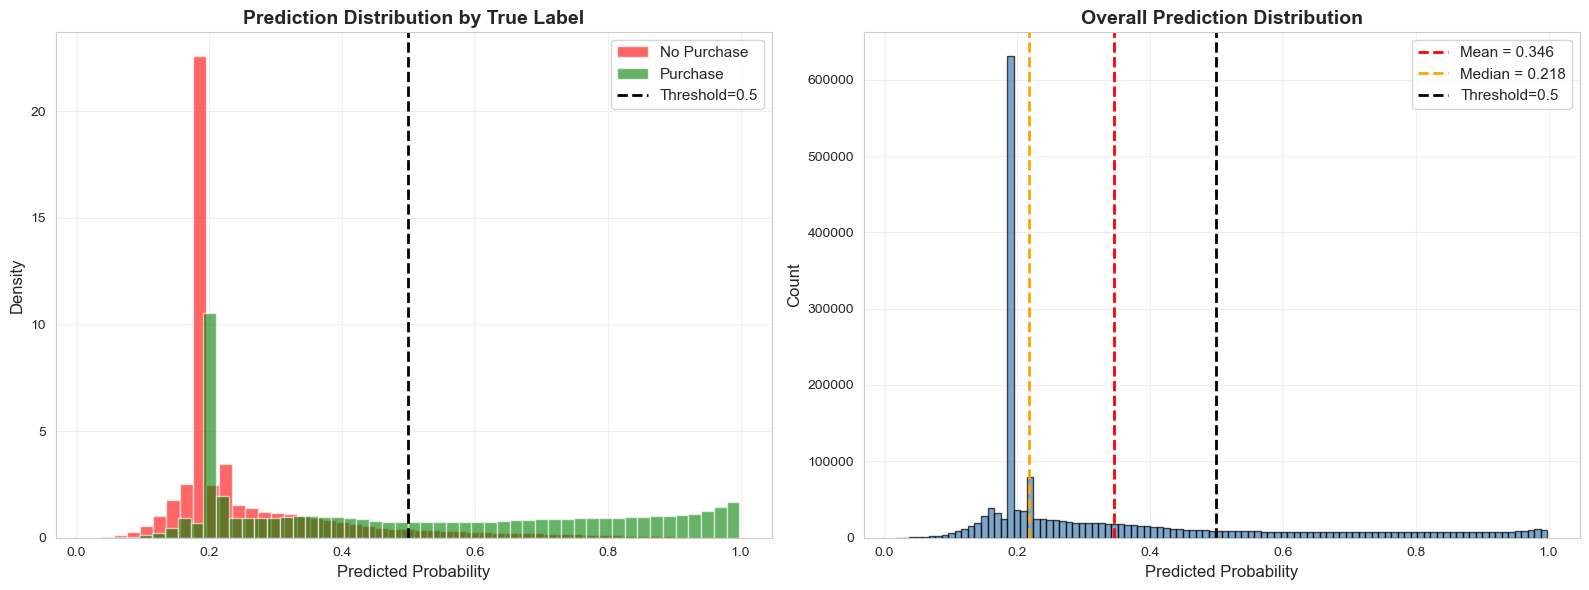

✅ Prediction distributions saved to ../results/figures/prediction_distribution.png


In [14]:
# Plot prediction distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution by true label
axes[0].hist(y_pred_ensemble[y == 0], bins=50, alpha=0.6, label='No Purchase', color='red', density=True)
axes[0].hist(y_pred_ensemble[y == 1], bins=50, alpha=0.6, label='Purchase', color='green', density=True)
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Prediction Distribution by True Label', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Overall distribution
axes[1].hist(y_pred_ensemble, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axvline(x=y_pred_ensemble.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {y_pred_ensemble.mean():.3f}')
axes[1].axvline(x=np.median(y_pred_ensemble), color='orange', linestyle='--', linewidth=2, 
                label=f'Median = {np.median(y_pred_ensemble):.3f}')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Overall Prediction Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'prediction_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Prediction distributions saved to {FIGURES_DIR}/prediction_distribution.png")

## 9. Calibration Plot

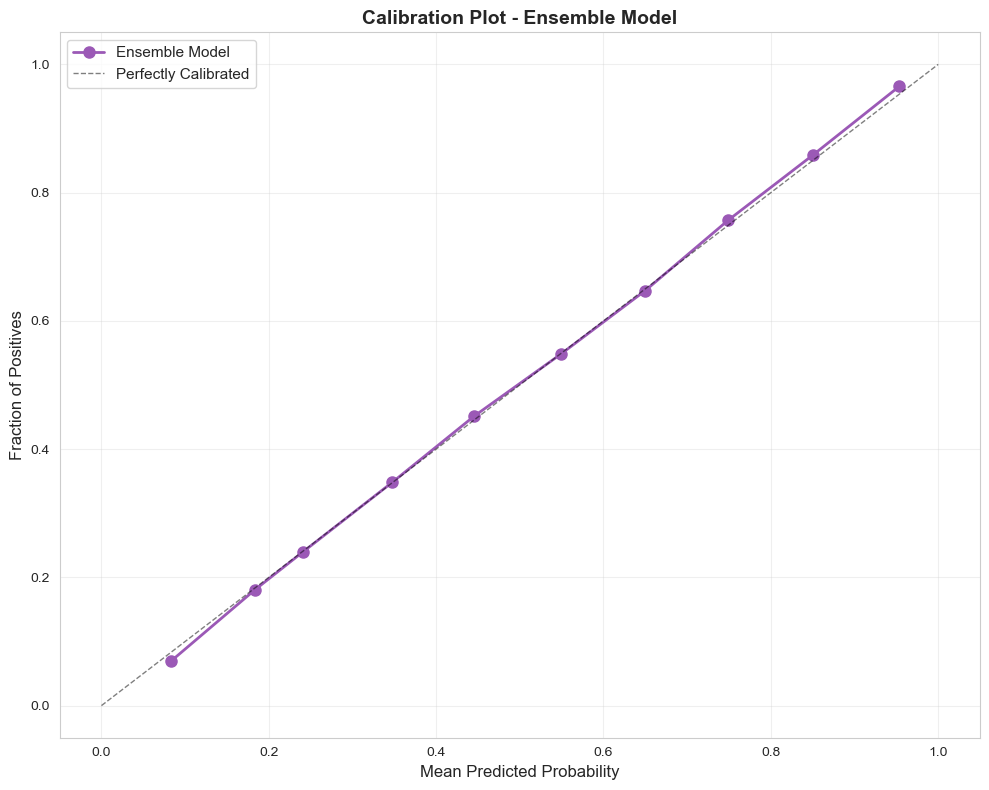

✅ Calibration plot saved to ../results/figures/calibration_plot.png

Brier Score: 0.1695 (lower is better)


In [15]:
# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y, y_pred_ensemble, n_bins=10, strategy='uniform')

plt.figure(figsize=(10, 8))

plt.plot(mean_predicted_value, fraction_of_positives, 'o-', linewidth=2, markersize=8, 
         label='Ensemble Model', color='#9b59b6')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfectly Calibrated', alpha=0.5)

plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Plot - Ensemble Model', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'calibration_plot.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Calibration plot saved to {FIGURES_DIR}/calibration_plot.png")
print(f"\nBrier Score: {metrics_ensemble['Brier Score']:.4f} (lower is better)")

## 10. Summary Report

In [16]:
print("="*80)
print("MODEL EVALUATION SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"   Total users: {len(df_train):,}")
print(f"   Positive class: {y.sum():,} ({y.mean():.2%})")
print(f"   Negative class: {(~y.astype(bool)).sum():,} ({(1-y.mean()):.2%})")
print(f"   Number of features: {X.shape[1]}")

print(f"\n🏆 Best Model: Ensemble")
print(f"   AUC-ROC: {metrics_ensemble['AUC-ROC']:.4f}")
print(f"   F1-Score: {metrics_ensemble['F1-Score']:.4f}")
print(f"   Precision: {metrics_ensemble['Precision']:.4f}")
print(f"   Recall: {metrics_ensemble['Recall']:.4f}")
print(f"   Log Loss: {metrics_ensemble['Log Loss']:.4f}")

print(f"\n📈 Improvements vs Baseline:")
baseline_auc = 0.7589  # From baseline.ipynb
improvement = (metrics_ensemble['AUC-ROC'] - baseline_auc) / baseline_auc * 100
print(f"   Baseline AUC: {baseline_auc:.4f}")
print(f"   Final AUC: {metrics_ensemble['AUC-ROC']:.4f}")
print(f"   Improvement: +{improvement:.2f}%")

print(f"\n✅ Generated Visualizations:")
print(f"   1. metrics_comparison.png")
print(f"   2. roc_curve_comparison.png")
print(f"   3. precision_recall_curve.png")
print(f"   4. confusion_matrix_ensemble.png")
print(f"   5. prediction_distribution.png")
print(f"   6. calibration_plot.png")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("1. Feature importance analysis (SHAP)")
print("2. Error analysis (false positives/negatives)")
print("3. Cross-validation analysis")
print("4. Business recommendations (Notebook 6)")
print("="*80)

MODEL EVALUATION SUMMARY

📊 Dataset:
   Total users: 1,835,147
   Positive class: 634,722 (34.59%)
   Negative class: 1,200,425 (65.41%)
   Number of features: 335

🏆 Best Model: Ensemble
   AUC-ROC: 0.7633
   F1-Score: 0.5778
   Precision: 0.7530
   Recall: 0.4688
   Log Loss: 0.5154

📈 Improvements vs Baseline:
   Baseline AUC: 0.7589
   Final AUC: 0.7633
   Improvement: +0.58%

✅ Generated Visualizations:
   1. metrics_comparison.png
   2. roc_curve_comparison.png
   3. precision_recall_curve.png
   4. confusion_matrix_ensemble.png
   5. prediction_distribution.png
   6. calibration_plot.png

NEXT STEPS
1. Feature importance analysis (SHAP)
2. Error analysis (false positives/negatives)
3. Cross-validation analysis
4. Business recommendations (Notebook 6)
